<a href="https://colab.research.google.com/github/torifinch/Loan_Approvals/blob/main/Loans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Approval Prediction Project
### Predicting Loan Status with Logistic Regression, Random Forest, and XGBoost

This notebook walks through a full ML workflow: data preprocessing, feature engineering, handling class imbalance with SMOTE, and evaluating model performance across Logistic Regression, Random Forest, and XGBoost. Final model selection is based on balanced performance metrics and feature importance insights.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
df = pd.read_csv('/content/loans_modified.csv')
df.head(10)

,loan_id,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
0,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,0.0
1,LP001005,Male,Yes,0,Graduate,NaN,3000.0,0.0,66.0,360.0,1.0,Urban,1.0
2,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,1.0
3,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,1.0
4,LP001011,Male,Yes,2,Graduate,Yes,5417.0,4196.0,267.0,360.0,1.0,Urban,1.0
5,LP001013,Male,Yes,0,Not Graduate,No,2333.0,1516.0,95.0,360.0,1.0,Urban,1.0
6,LP001014,Male,Yes,3+,Graduate,No,3036.0,2504.0,158.0,360.0,0.0,NaN,0.0
7,LP001018,Male,Yes,2,Graduate,No,4006.0,1526.0,168.0,360.0,1.0,NaN,1.0
8,LP001020,Male,Yes,1,Graduate,No,12841.0,10968.0,349.0,360.0,1.0,Semiurban,0.0
9,LP001024,Male,Yes,2,Graduate,No,3200.0,700.0,70.0,360.0,1.0,Urban,1.0


In [72]:
# Check nan
df.isna().sum()

,0
loan_id,29
gender,29
married,19
dependents,32
education,22
self_employed,34
applicant_income,26
coapplicant_income,34
loan_amount,30
loan_amount_term,28


In [73]:
df.shape

(563, 13)

In [74]:
# drop nan loan_id
# This is the unique identifier for each loan
df = df.dropna(subset=['loan_id'])

In [75]:
# Drop nan loan status
# This is the target variable for prediction
df = df.dropna(subset=['loan_status'])

In [76]:
# Change nan categorical features to mode
df['property_area'] = df['property_area'].fillna(df['property_area'].mode()[0])
df['self_employed'] = df['self_employed'].fillna(df['self_employed'].mode()[0])
df['education'] = df['education'].fillna(df['education'].mode()[0])
df['married'] = df['married'].fillna(df['married'].mode()[0])
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])
df['dependents'] = df['dependents'].fillna(df['dependents'].mode()[0])
df['loan_amount_term'] = df['loan_amount_term'].fillna(df['loan_amount_term'].mode()[0])
df['credit_history'] = df['credit_history'].fillna(df['credit_history'].mode()[0])

In [77]:
# Change nan numerical feaures to mean
df['coapplicant_income'] = df['coapplicant_income'].fillna(df['coapplicant_income'].mean())
df['applicant_income'] = df['applicant_income'].fillna(df['applicant_income'].mean())

In [78]:
# Step 1: Create the missingness indicator
df['loan_amount_missing'] = df['loan_amount'].isnull().astype(int)

# Step 2: Impute the missing values (mean, median, or a model-based imputation)
df['loan_amount'] = df['loan_amount'].fillna(df['loan_amount'].median())

In [79]:
# Check nan
df.isna().sum()

,0
loan_id,0
gender,0
married,0
dependents,0
education,0
self_employed,0
applicant_income,0
coapplicant_income,0
loan_amount,0
loan_amount_term,0


In [80]:
# Check outliers
Q4 = df['loan_amount'].quantile(0.75)
Q1 = df['loan_amount'].quantile(0.25)
IQR = Q4 - Q1

outliers = df[(df['loan_amount'] < Q1 - 1.5 * IQR) | (df['loan_amount'] > Q4 + 1.5 * IQR)]
outliers.head(10)

,loan_id,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status,loan_amount_missing
4,LP001011,Male,Yes,2,Graduate,Yes,5417.0,4196.0,267.0,360.0,1.0,Urban,1.0,0
8,LP001020,Male,Yes,1,Graduate,No,12841.0,10968.0,349.0,360.0,1.0,Semiurban,0.0,0
19,LP001046,Male,Yes,1,Graduate,No,5955.0,5625.0,315.0,360.0,1.0,Urban,1.0,0
31,LP001100,Male,No,3+,Graduate,No,12500.0,3000.0,320.0,360.0,1.0,Rural,0.0,0
47,LP001186,Female,Yes,1,Graduate,Yes,11500.0,0.0,286.0,360.0,0.0,Urban,0.0,0
57,LP001225,Male,Yes,0,Graduate,No,5726.0,4595.0,258.0,360.0,1.0,Semiurban,0.0,0
59,LP001233,Male,Yes,1,Graduate,No,10750.0,0.0,312.0,360.0,1.0,Urban,1.0,0
73,LP001273,Male,Yes,0,Graduate,No,6000.0,2250.0,265.0,360.0,1.0,Semiurban,0.0,0
108,LP001469,Male,No,0,Graduate,Yes,20166.0,0.0,650.0,480.0,1.0,Urban,1.0,0
133,LP001536,Male,Yes,3+,Graduate,No,39999.0,0.0,600.0,180.0,0.0,Semiurban,1.0,0


In [81]:
# Smooth outliers
from scipy import stats
z_scores = np.abs(stats.zscore(df['loan_amount']))
df = df[(z_scores < 3)]

In [82]:
# Create household_income feature
df['household_income'] = df['applicant_income'] + df['coapplicant_income']

<ipython-input-82-c8286eade557>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['household_income'] = df['applicant_income'] + df['coapplicant_income']


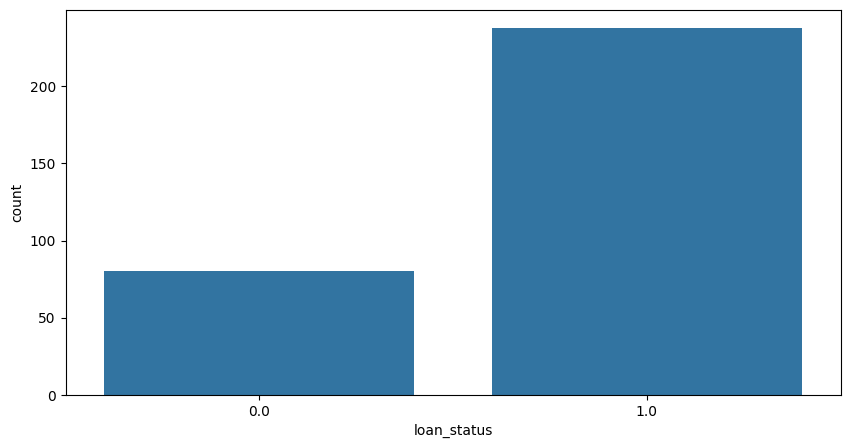

In [83]:
# Check loan status for married with dependants not 0
df_family = df[(df['married'] == 'Yes') & (df['dependents'] != 0)]
df_family['loan_status'].value_counts()
plt.figure(figsize=(10, 5))
sns.countplot(x='loan_status', data=df_family)
plt.show()

In [84]:
# percentage of loan status
df_family['loan_status'].value_counts(normalize=True)


,proportion
loan_status,
1.0,0.748428
0.0,0.251572


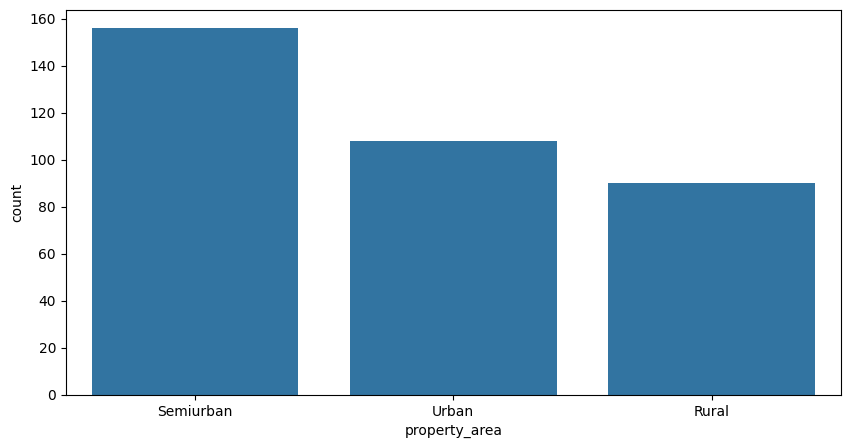

In [85]:
# Top property area of approved loans
plt.figure(figsize=(10, 5))
sns.countplot(x='property_area', data=df[df['loan_status'] == 1], order=df[df['loan_status'] == 1]['property_area'].value_counts().index)
plt.show()

In [86]:
# self employed salaries
df_self_employed = df[df['self_employed'] == 'Yes']
df_self_employed['loan_status'].value_counts(normalize=True)

,proportion
loan_status,
1.0,0.666667
0.0,0.333333


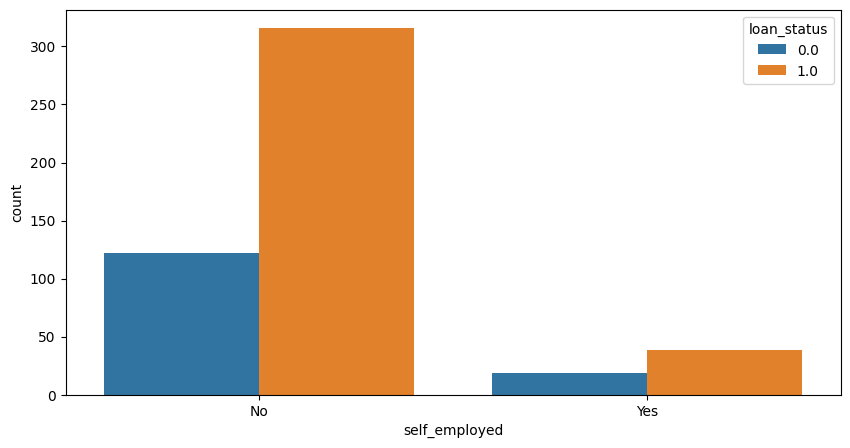

In [87]:
# Self employed loan approvals
plt.figure(figsize=(10, 5))
sns.countplot(x='self_employed', data=df, hue='loan_status')
plt.show()

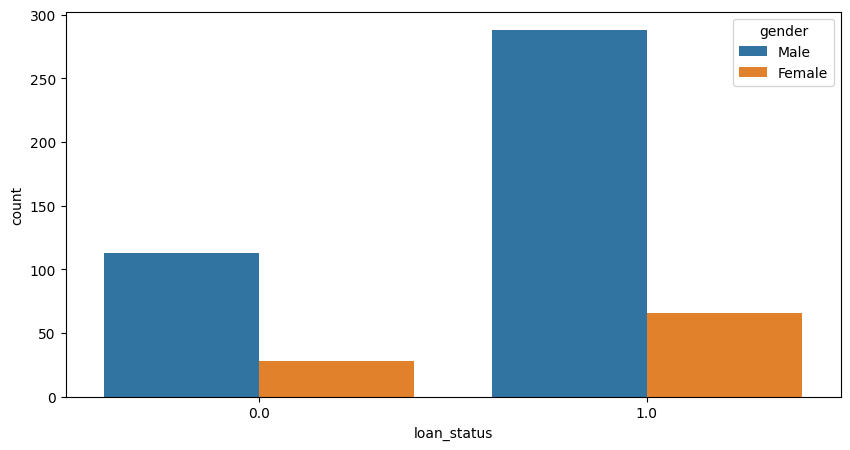

In [88]:
# Loan status apprval by gender
df_gender = df[(df['gender'] == 'Male') | (df['gender'] == 'Female')]
plt.figure(figsize=(10, 5))
sns.countplot(x='loan_status', data=df_gender, hue='gender')
plt.show()

In [89]:
df['applicant_income'].describe()

,applicant_income
count,495.000000
mean,5054.121596
std,5137.603905
min,150.000000
25%,2975.500000
50%,3875.000000
75%,5494.000000
max,81000.000000


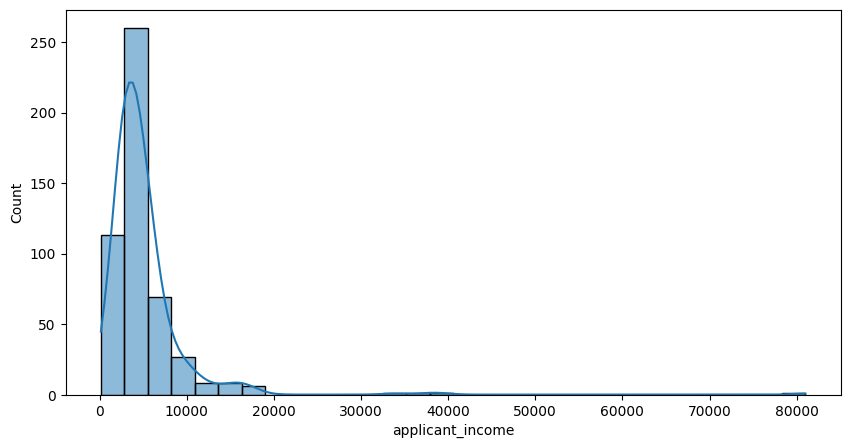

In [90]:
# Applicant income distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['applicant_income'], bins=30, kde=True)
plt.show()

###Skewness / log1p

In [91]:
# This is right skewed because of a long tail on the right
#This reduces the impact of large income outliers while keeping zeros valid.
#income and loan amaount
df['log_applicant_income'] = np.log1p(df['applicant_income'])
df['log_coapplicant_income'] = np.log1p(df['coapplicant_income'])
df['log_loan_amount'] = np.log1p(df['loan_amount'])
df['log_household_income'] = np.log1p(df['household_income'])

In [92]:
df['household_income'].skew()
#+1 = right-skewed
#< -1 = left-skewed
#Between -0.5 and 0.5 is roughly symmetric (no action needed)

np.float64(6.658735444632674)

In [93]:
df['log_household_income'].skew()

np.float64(1.0562794374686755)

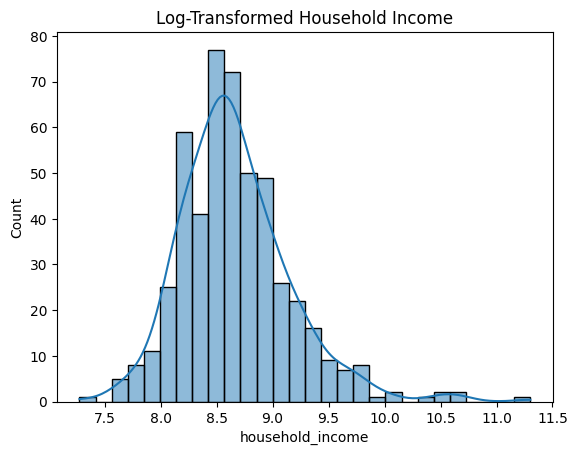

In [94]:
sns.histplot(np.log1p(df['household_income']), kde=True)
plt.title("Log-Transformed Household Income")
plt.show()

In [95]:
df['income_category'] = pd.cut(df['applicant_income'], bins=[0, 2500, 5000, 10000, np.inf], labels=['Low', 'Medium', 'High', 'Very High'])
df.groupby('income_category')['loan_status'].value_counts(normalize=True)

<ipython-input-95-9df48fcfb989>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('income_category')['loan_status'].value_counts(normalize=True)


income_category  loan_status
Low              1.0            0.705882
                 0.0            0.294118
Medium           1.0            0.719512
                 0.0            0.280488
High             1.0            0.734848
                 0.0            0.265152
Very High        1.0            0.625000
                 0.0            0.375000
Name: proportion, dtype: float64

In [96]:
# Loan approval by household_income category
df['household_income_category'] = pd.cut(df['household_income'], bins=[0, 5000, 10000, 15000, 20000, np.inf], labels=['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k+'])
df.groupby('household_income_category')['loan_status'].value_counts(normalize=True)


<ipython-input-96-a8baca88901a>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('household_income_category')['loan_status'].value_counts(normalize=True)


household_income_category  loan_status
0-5k                       1.0            0.691176
                           0.0            0.308824
5k-10k                     1.0            0.757576
                           0.0            0.242424
10k-15k                    1.0            0.692308
                           0.0            0.307692
15k-20k                    1.0            0.666667
                           0.0            0.333333
20k+                       0.0            0.666667
                           1.0            0.333333
Name: proportion, dtype: float64

In [97]:
# loan pivot table with income level and loan amount
df_pivot = df.pivot_table(index='income_category', values='loan_amount', aggfunc='mean')
df_pivot

<ipython-input-97-e92af2dd7b48>:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df.pivot_table(index='income_category', values='loan_amount', aggfunc='mean')


,loan_amount
income_category,
Low,108.317647
Medium,120.857724
High,172.121212
Very High,202.125000


In [98]:
# Avg income to loan ratio
loan_ratio = df.groupby('income_category')['loan_amount'].mean() / df.groupby('income_category')['applicant_income'].mean()
loan_ratio

<ipython-input-98-2efd8eb36e47>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_ratio = df.groupby('income_category')['loan_amount'].mean() / df.groupby('income_category')['applicant_income'].mean()


,0
income_category,
Low,0.054102
Medium,0.033334
High,0.026281
Very High,0.011245


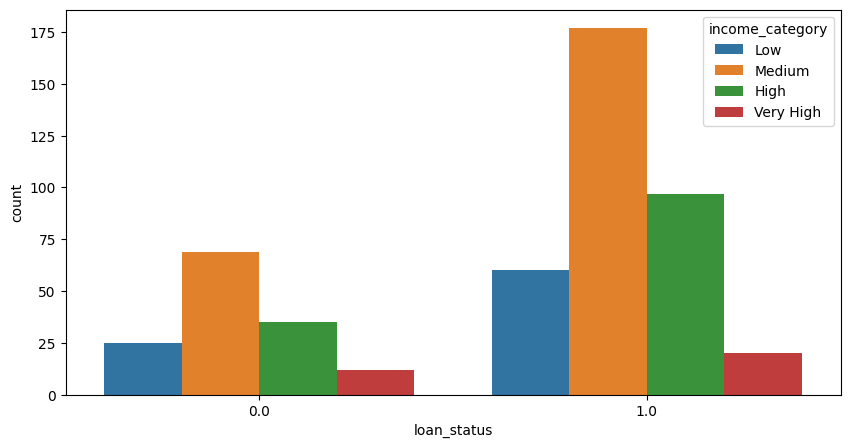

In [99]:
plt.figure(figsize=(10, 5))
sns.countplot(x='loan_status', data=df, hue='income_category')
plt.show()

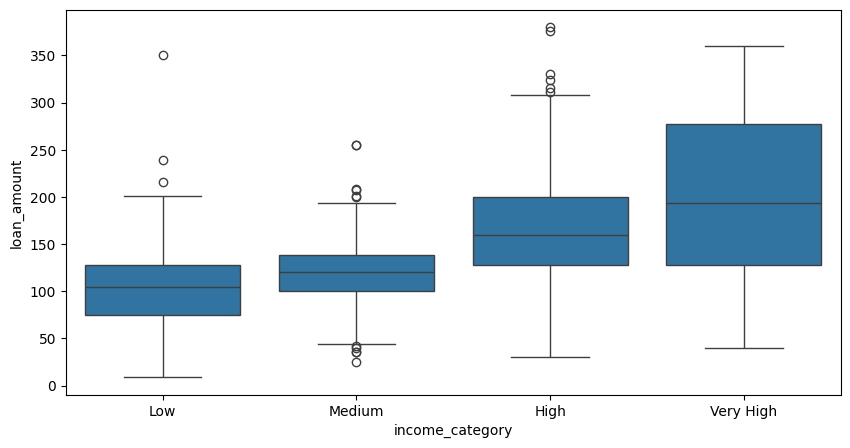

In [100]:
# Check loan amount with income category
plt.figure(figsize=(10, 5))
sns.boxplot(x='income_category', y='loan_amount', data=df)
plt.show()

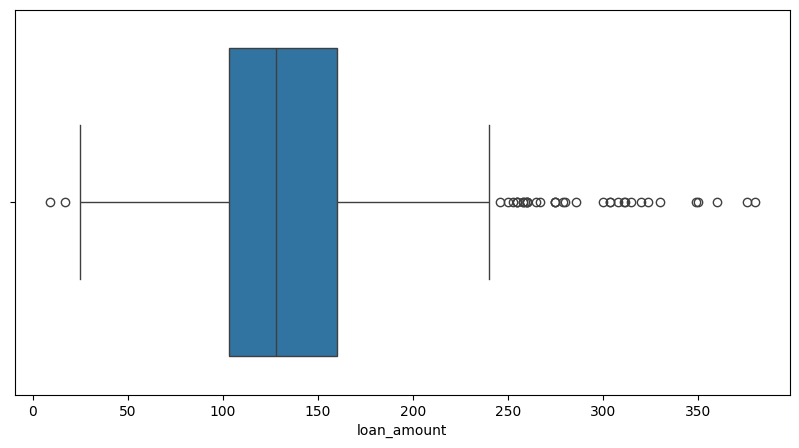

In [101]:
# Check outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x='loan_amount', data=df)
plt.show()

In [102]:
Q4 = df['loan_amount'].quantile(0.75)
Q1 = df['loan_amount'].quantile(0.25)
IQR = Q4 - Q1

outliers = df[(df['loan_amount'] < Q1 - 1.5 * IQR) | (df['loan_amount'] > Q4 + 1.5 * IQR)]
outliers.head(10)

,loan_id,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,...,property_area,loan_status,loan_amount_missing,household_income,log_applicant_income,log_coapplicant_income,log_loan_amount,log_household_income,income_category,household_income_category
4,LP001011,Male,Yes,2,Graduate,Yes,5417.0,4196.0,267.0,360.0,...,Urban,1.0,0,9613.0,8.597482,8.342125,5.590987,9.170976,High,5k-10k
8,LP001020,Male,Yes,1,Graduate,No,12841.0,10968.0,349.0,360.0,...,Semiurban,0.0,0,23809.0,9.460476,9.302828,5.857933,10.077861,Very High,20k+
13,LP001030,Male,Yes,2,Graduate,No,1299.0,1086.0,17.0,120.0,...,Urban,1.0,0,2385.0,7.170120,6.991177,2.890372,7.777374,Low,0-5k
19,LP001046,Male,Yes,1,Graduate,No,5955.0,5625.0,315.0,360.0,...,Urban,1.0,0,11580.0,8.692154,8.635154,5.755742,9.357121,High,10k-15k
31,LP001100,Male,No,3+,Graduate,No,12500.0,3000.0,320.0,360.0,...,Rural,0.0,0,15500.0,9.433564,8.006701,5.771441,9.648660,Very High,15k-20k
47,LP001186,Female,Yes,1,Graduate,Yes,11500.0,0.0,286.0,360.0,...,Urban,0.0,0,11500.0,9.350189,0.000000,5.659482,9.350189,Very High,10k-15k
57,LP001225,Male,Yes,0,Graduate,No,5726.0,4595.0,258.0,360.0,...,Semiurban,0.0,0,10321.0,8.652947,8.432942,5.556828,9.242033,High,10k-15k
59,LP001233,Male,Yes,1,Graduate,No,10750.0,0.0,312.0,360.0,...,Urban,1.0,0,10750.0,9.282754,0.000000,5.746203,9.282754,Very High,10k-15k
73,LP001273,Male,Yes,0,Graduate,No,6000.0,2250.0,265.0,360.0,...,Semiurban,0.0,0,8250.0,8.699681,7.719130,5.583496,9.018090,High,5k-10k
137,LP001552,Male,Yes,0,Graduate,No,4583.0,5625.0,255.0,360.0,...,Semiurban,1.0,0,10208.0,8.430327,8.635154,5.545177,9.231025,Medium,10k-15k


In [103]:
# Logistic regression
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
df = pd.read_csv('/content/loans_modified.csv')
df.head(10)

,loan_id,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
0,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,0.0
1,LP001005,Male,Yes,0,Graduate,NaN,3000.0,0.0,66.0,360.0,1.0,Urban,1.0
2,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,1.0
3,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,1.0
4,LP001011,Male,Yes,2,Graduate,Yes,5417.0,4196.0,267.0,360.0,1.0,Urban,1.0
5,LP001013,Male,Yes,0,Not Graduate,No,2333.0,1516.0,95.0,360.0,1.0,Urban,1.0
6,LP001014,Male,Yes,3+,Graduate,No,3036.0,2504.0,158.0,360.0,0.0,NaN,0.0
7,LP001018,Male,Yes,2,Graduate,No,4006.0,1526.0,168.0,360.0,1.0,NaN,1.0
8,LP001020,Male,Yes,1,Graduate,No,12841.0,10968.0,349.0,360.0,1.0,Semiurban,0.0
9,LP001024,Male,Yes,2,Graduate,No,3200.0,700.0,70.0,360.0,1.0,Urban,1.0


In [105]:
df.isna().sum()

,0
loan_id,29
gender,29
married,19
dependents,32
education,22
self_employed,34
applicant_income,26
coapplicant_income,34
loan_amount,30
loan_amount_term,28


In [106]:
# Drop loan_id nans and loan_status nan
df = df.dropna(subset=['loan_id'])
df = df.dropna(subset=['loan_status'])

In [107]:
# Preprocess Data

# Create the missingness indicator
df['loan_amount_missing'] = df['loan_amount'].isnull().astype(int)
df['self_employed_missing'] = df['self_employed'].isnull().astype(int)

# Fill categorical with 'Unknown' or average
categorical_cols = ['gender', 'married', 'dependents', 'education', 'self_employed', 'property_area', 'credit_history']
#df[categorical_cols] = df[categorical_cols].fillna('Unknown')
for i in categorical_cols:
  df[i] = df[i].fillna(df[i].mode()[0])

# Fill numerical with median
numerical_cols = ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term']
for i in numerical_cols:
  df[i] = df[i].fillna(df[i].median())

# Skew Income data
df['log_applicant_income'] = np.log1p(df['applicant_income'])
df['log_coapplicant_income'] = np.log1p(df['coapplicant_income'])

In [108]:
# Feature Engineering
# Total income
df['total_income'] = df['applicant_income'] + df['coapplicant_income']
df['loan_to_income'] = df['loan_amount'] / (df['total_income'] + 1)  # +1 to avoid divide by zero
df['is_family'] = (df['dependents'] != 0).astype(int) & (df['married'] == 'Yes').astype(int)

In [109]:
numerical_cols = ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term', 'total_income', 'loan_to_income', 'is_family']

In [110]:
# Encode Categorical Features
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

In [111]:
# Train/Test Split
X = pd.concat([df[numerical_cols], df_encoded], axis=1)
y = df['loan_status']  # 1 = approved, 0 = rejected

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
df.isna().sum()

,0
loan_id,0
gender,0
married,0
dependents,0
education,0
self_employed,0
applicant_income,0
coapplicant_income,0
loan_amount,0
loan_amount_term,0


#Logistic Regresssion

In [113]:
# Fit the Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [114]:
# Evaluate the Model
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 7 14]
 [ 3 78]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.33      0.45        21
         1.0       0.85      0.96      0.90        81

    accuracy                           0.83       102
   macro avg       0.77      0.65      0.68       102
weighted avg       0.82      0.83      0.81       102



In [115]:
# Check Coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
print(coefficients)

                    Feature  Coefficient
7            credit_history     3.123297
15  property_area_Semiurban     0.356216
9               married_Yes     0.331289
6                 is_family     0.331289
12            dependents_3+     0.311206
11             dependents_2     0.080639
14        self_employed_Yes     0.047324
0          applicant_income     0.000032
4              total_income    -0.000026
1        coapplicant_income    -0.000058
2               loan_amount    -0.001500
3          loan_amount_term    -0.001653
16      property_area_Urban    -0.028670
5            loan_to_income    -0.091910
13   education_Not Graduate    -0.220573
8               gender_Male    -0.381802
10             dependents_1    -0.541396


#Random Forest

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [117]:
X = pd.concat([df[numerical_cols], df_encoded], axis=1)
y = df['loan_status']

# SMOTE
Fix imbalances in Data

In [118]:
smote_model = SMOTE(random_state=42)
X_resampled, y_resampled = smote_model.fit_resample(X, y)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [120]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [121]:
y_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[55 10]
 [15 66]]
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.81        65
         1.0       0.87      0.81      0.84        81

    accuracy                           0.83       146
   macro avg       0.83      0.83      0.83       146
weighted avg       0.83      0.83      0.83       146



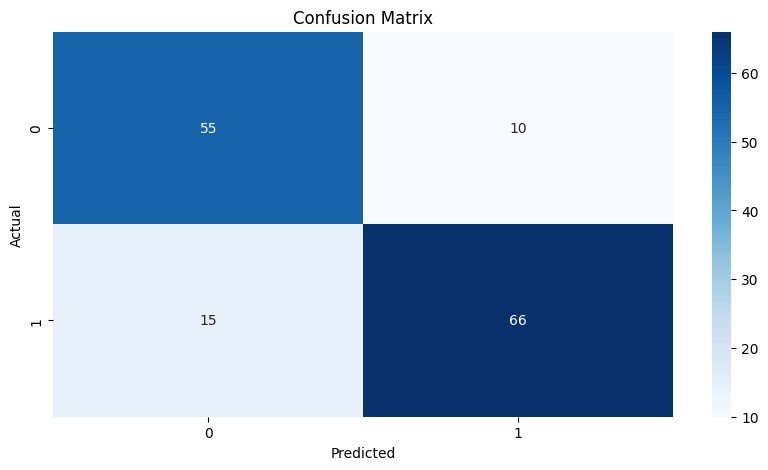

In [122]:
# Confusion Matrix
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [123]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances.head(10))

                Feature  Importance
7        credit_history    0.184828
5        loan_to_income    0.133872
0      applicant_income    0.132622
4          total_income    0.113467
2           loan_amount    0.106045
1    coapplicant_income    0.080470
10         dependents_1    0.038138
6             is_family    0.035908
3      loan_amount_term    0.031989
16  property_area_Urban    0.025347


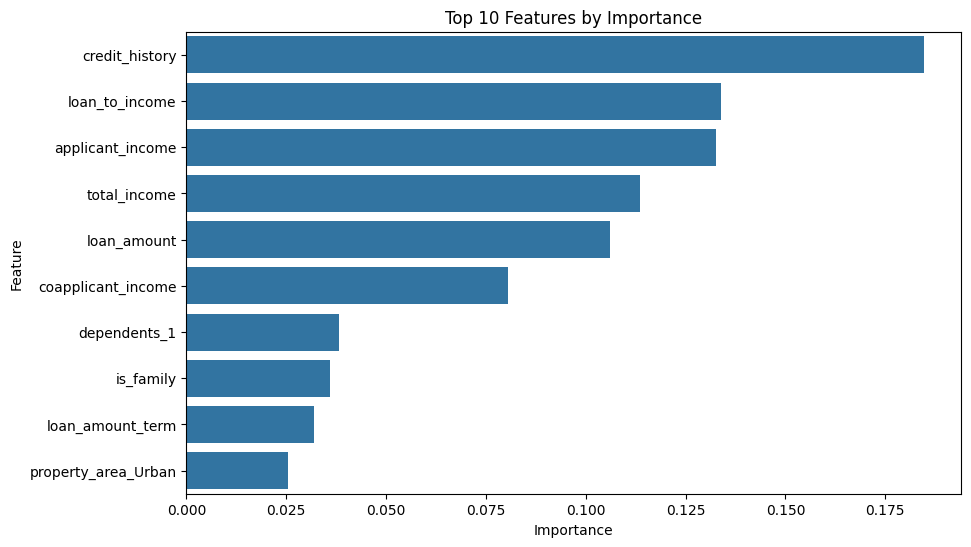

In [124]:
# Vizualize results
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(10))
plt.title('Top 10 Features by Importance')
plt.show()

Tune hyperparameters with GridSearchCV

In [125]:
#GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 15, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 15, 25],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [126]:
# Best results
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.8603448275862069


In [127]:
# Retrain Model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[55 10]
 [13 68]]
              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83        65
         1.0       0.87      0.84      0.86        81

    accuracy                           0.84       146
   macro avg       0.84      0.84      0.84       146
weighted avg       0.84      0.84      0.84       146



#XGBoost

In [128]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [129]:
X, y = smote_model.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
xgmodel = xgb.XGBClassifier(random_state=42)
xgmodel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [131]:
y_pred = xgmodel.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[54 11]
 [16 65]]
              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80        65
         1.0       0.86      0.80      0.83        81

    accuracy                           0.82       146
   macro avg       0.81      0.82      0.81       146
weighted avg       0.82      0.82      0.82       146



##Hyperparameter tuning
Using Grid Search

In [132]:
# Set params

params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(xgmodel, params, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             verbose=2)

In [133]:
y_pred = grid_search.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[53 12]
 [15 66]]
              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80        65
         1.0       0.85      0.81      0.83        81

    accuracy                           0.82       146
   macro avg       0.81      0.82      0.81       146
weighted avg       0.82      0.82      0.82       146

